# Импорты

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
from tqdm import tqdm
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
%matplotlib inline

In [ ]:
!pip3 install -q gymnasium[classic-control]

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from typing import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Среда №1

## Код среды

### MDP

In [ ]:
import random

class MDP:
    """ Return all states of this MDP """

    def get_states(self):
        pass

    """ Return all actions with non-zero probability from this state """

    def get_actions(self, state):
        pass

    """ Return all non-zero probability transitions for this action
        from this state, as a list of (state, probability) pairs
    """

    def get_transitions(self, state, action):
        pass

    """ Return the reward for transitioning from state to
        nextState via action
    """

    def get_reward(self, state, action, next_state):
        pass

    """ Return true if and only if state is a terminal state of this MDP """

    def is_terminal(self, state):
        pass

    """ Return the discount factor for this MDP """

    def get_discount_factor(self):
        pass

    """ Return the initial state of this MDP """

    def get_initial_state(self):
        pass

    """ Return all goal states of this MDP """

    def get_goal_states(self):
        pass

    """ Return a new state and a reward for executing action in state,
    based on the underlying probability. This can be used for
    model-free learning methods, but requires a model to operate.
    Override for simulation-based learning
    """

    def execute(self, state, action):
        rand = random.random()
        cumulative_probability = 0.0
        for (new_state, probability) in self.get_transitions(state, action):
            if cumulative_probability <= rand <= probability + cumulative_probability:
                return (new_state, self.get_reward(state, action, new_state))
            cumulative_probability += probability
            if cumulative_probability >= 1.0:
                raise (
                    "Cumulative probability >= 1.0 for action "
                    + str(action)
                    + " from "
                    + str(state)
                )

        raise (
            "No outcome state in simulation for action"
            + str(action)
            + " from "
            + str(state)
        )

    """ Execute a policy on this mdp for a number of episodes """

    def execute_policy(self, policy, episodes=100, max_iterations=1000):
        for _ in range(episodes):
            state = self.get_initial_state()
            iteration = 0
            cummulative_reward = 0
            while not self.is_terminal(state) and iteration < max_iterations:
                action = policy[state]
                (next_state, reward) = self.execute(state, action)
                cummulative_reward += reward
                state = next_state
                iteration += 1
        return (state, cummulative_reward)

### Rendering

In [ ]:
import math
import matplotlib.colors as colours
import matplotlib.pyplot as plt

COLOURS = {
    'red': [200, 50, 50],
    'green': [90, 165, 90],
    'blue': [0, 0, 255],
    'purple': [112, 39, 195],
    'grey': [150, 150, 150],
    'white': [255, 255, 255],
    'black': [0, 0, 0],
    'yellow': [255, 255, 0]
}

# Action symbols from gridworld
LEFT = '\u25C4'
UP = '\u25B2'
RIGHT = '\u25BA'
DOWN = '\u25BC'

'''Draw the grid lines to differentiate discrete states'''
def draw_grid_lines(i, j, img):
    img[i][j] = COLOURS['black']


'''Draw a triangle based on size, center, direction and colour'''
def draw_triangle(tile_origin, tile_size, img, colour='red', direction='up'):
    origin_x, origin_y = tile_origin
    for x in range(origin_x + 1, origin_x + tile_size - 1):
        for y in range(origin_y + 1, origin_y + tile_size -1):
            if direction == DOWN:
                if y < origin_y + tile_size//2 and x + y < origin_x + origin_y + tile_size and x - origin_x > y - origin_y:
                    img[y][x] = colour
            elif direction == UP:
                if y > origin_y + tile_size // 2 and x + y > origin_x + origin_y + tile_size and x - origin_x < y - origin_y:
                    img[y][x] = colour
            elif direction == LEFT:
                if x < origin_x + tile_size // 2 and x - origin_x < y - origin_y and x + y < origin_x + origin_y + tile_size:
                    img[y][x] = colour
            elif direction == RIGHT:
                if x > origin_x + tile_size // 2 and x - origin_x > y - origin_y and x + y > origin_x + origin_y + tile_size:
                    img[y][x] = colour
            else:
                raise ValueError("Invalid direction")


''' Render each Q value which forms a triangle in the grid representation of the Q-function.'''
def render_action_q_value(tileSize, x, y, action, q_values, img, show_text=False, text_size=12, h_text_offset=0, v_text_offset=0, rewardMax=1, rewardMin=1):
    value = q_values.get_q_value((x, y), action) #MDP.get_q_value(q_values, (x, y), action=action)
    colour = COLOURS['red'] if value < 0 else COLOURS['green']  # make colour red if value is negative, otherwise make it green
    scaling_factor = rewardMin if value < 0 else rewardMax
    colour = list(map(lambda c: int(c * math.fabs(value/scaling_factor)),
                      colour))  # scale the colour by the reward (make extremes more vivid)
    draw_triangle((x * tileSize, y * tileSize), tileSize, img, colour=colour, direction=action)
    if show_text:
        plt.text(x=x * tileSize + tileSize // 2 + h_text_offset, y=y * tileSize + tileSize // 2 + v_text_offset,
                 s=f'{value:.2f}', size=text_size, verticalalignment='center', horizontalalignment='center', color='white')


''' Render each Q value which forms a triangle in the grid representation of the Q-function.'''
def render_action_probability(tileSize, x, y, action, prob, text_size=6, h_text_offset=0, v_text_offset=0):
    plt.text(x=x * tileSize + tileSize // 2 + h_text_offset, y=y * tileSize + tileSize // 2 + v_text_offset,
             s=f'{prob:.2f}\n{action}', size=text_size, verticalalignment='center', horizontalalignment='center', color='white')


'''render blocked tile as a black and white criss-cross'''
def render_blocked_tile(i, j, img):
    img[i][j] = COLOURS['grey']
    """
    EDIT
    if i % 2 == 0 or j % 2 == 0:
        img[i][j] = COLOURS['black']
    else:
        img[i][j] = COLOURS['white']
    """

def render_full_blocked_tile(x, y, tile_size, img):
    for i in range(x, x+tile_size):
        for j in range(y, y+tile_size):
            if i % 2 == 0 or j % 2 == 0:
                img[j][i] = COLOURS['black']
            else:
                img[j][i] = COLOURS['white']


def render_full_goal_tile(x, y, tile_size, img, reward, rewardMax, rewardMin):
    for i in range(x, x+tile_size):
        for j in range(y, y+tile_size):
            if reward > 0:
                img[j][i] = [0, int(255 * reward / rewardMax), 0]
            else:
                img[j][i] = [int(255 * reward / rewardMin), 0, 0]


'''render the agent as a circle'''
def render_agent(i, j, img, center_x, center_y, radius):
    h_dist = math.fabs(center_x - j)
    v_dist = math.fabs(center_y - i)
    if h_dist ** 2 + v_dist ** 2 <= radius ** 2:
        img[i][j] = COLOURS['yellow']
    else:
        img[i][j] = COLOURS['white']


'''
Render the goal as a coloured cell. THe color depend on the value of the goal.
Positive values are green, with brighter green representing higher reward.
Negative values are red, with brighter red representing lower reward.
'''
def render_goal(i, j, img, reward, reward_max=1, reward_min=-1):
    """
    EDIT
    if reward > 0:
        img[i][j] = [0, int(255 * reward / reward_max), 0]
    else:
        img[i][j] = [int(255 * reward / reward_min), 0, 0]
    """
    img[i][j] = COLOURS['white']
    tileSize = 32
    plt.text(x = i* tileSize/2 , y=j* tileSize/2 , s=f'{reward:.2f}', size=12)
    #plt.text(x=i * tileSize + tileSize // 2 + 8, y=j * tileSize + tileSize // 2 + 8,
    #             s=f'{reward:.2f}', size=12, verticalalignment='center', horizontalalignment='center', color='white')

'''
Matplotlib doesn't have an inbuilt red to green colour map with white in the middle.
So we can just make our own.
'''
def make_red_white_green_cmap():
    cdict = {'red': ((0.0, 1.0, 1.0),
                     (0.5, 1.0, 1.0),
                     (1.0, 0.0, 0.0)),
             'green': ((0.0, 0.0, 0.0),
                       (0.5, 1.0, 1.0),
                       (1.0, 1.0, 1.0)),
             'blue': ((0.0, 0.0, 0.0),
                      (0.5, 1.0, 1.0),
                      (1.0, 0.0, 0.0))
             }

    # Create the colormap using the dictionary
    return colours.LinearSegmentedColormap('GnRd', cdict)

### Grid World

In [ ]:
from collections import defaultdict


class GridWorld(MDP):
    # labels for terminate action and terminal state
    TERMINATE = 'terminate'
    TERMINAL = ('terminal', 'terminal')
    LEFT = '\u25C4'
    UP = '\u25B2'
    RIGHT = '\u25BA'
    DOWN = '\u25BC'

    def __init__(
        self,
        noise=0.1,
        width=4,
        height=3,
        discount_factor=0.9,
        blocked_states=[(1, 1)],
        action_cost=0.0,
        initial_state=(0, 0),
        goals=None,
    ):
        self.noise = noise
        self.width = width
        self.height = height
        self.blocked_states = blocked_states
        self.discount_factor = discount_factor
        self.action_cost = action_cost
        self.initial_state = initial_state
        if goals is None:
            self.goal_states = dict(
                [((width - 1, height - 1), 1), ((width - 1, height - 2), -1)]
            )
        else:
            self.goal_states = dict(goals)

        # A list of lists thatrecords all rewards given at each step
        # for each episode of a simulated gridworld
        self.rewards = []
        # The rewards for the current episode
        self.episode_rewards = []


    def get_states(self):
        states = [self.TERMINAL]
        for x in range(self.width):
            for y in range(self.height):
                if not (x, y) in self.blocked_states:
                    states.append((x, y))
        return states

    def get_actions(self, state=None):
        actions = [self.UP, self.DOWN, self.LEFT, self.RIGHT, self.TERMINATE]
        if state is None:
            return actions

        valid_actions = []
        for action in actions:
            for (new_state, probability) in self.get_transitions(state, action):
                if probability > 0:
                    valid_actions.append(action)
                    break
        return valid_actions

    def get_initial_state(self):
        self.episode_rewards = []
        return self.initial_state

    def get_goal_states(self):
        return self.goal_states

    def valid_add(self, state, new_state, probability):
        # If the next state is blocked, stay in the same state
        if probability == 0.0:
            return []

        if new_state in self.blocked_states:
            return [(state, probability)]

        # Move to the next space if it is not off the grid
        (x, y) = new_state
        if x >= 0 and x < self.width and y >= 0 and y < self.height:
            return [((x, y), probability)]

        # If off the grid, state in the same state
        return [(state, probability)]

    def get_transitions(self, state, action):
        transitions = []

        if state == self.TERMINAL:
            if action == self.TERMINATE:
                return [(self.TERMINAL, 1.0)]
            else:
                return []

        # Probability of not slipping left or right
        straight = 1 - (2 * self.noise)

        (x, y) = state
        if state in self.get_goal_states().keys():
            if action == self.TERMINATE:
                transitions += [(self.TERMINAL, 1.0)]

        elif action == self.UP:
            transitions += self.valid_add(state, (x, y + 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.DOWN:
            transitions += self.valid_add(state, (x, y - 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.RIGHT:
            transitions += self.valid_add(state, (x + 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        elif action == self.LEFT:
            transitions += self.valid_add(state, (x - 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        # Merge any duplicate outcomes
        merged = defaultdict(lambda: 0.0)
        for (state, probability) in transitions:
            merged[state] = merged[state] + probability

        transitions = []
        for outcome in merged.keys():
            transitions += [(outcome, merged[outcome])]

        return transitions

    def get_reward(self, state, action, new_state):
        reward = 0.0
        if state in self.get_goal_states().keys() and new_state == self.TERMINAL:
            reward = self.get_goal_states().get(state)
        else:
            # default：0
            reward = self.action_cost
        step = len(self.episode_rewards)
        self.episode_rewards += [reward * (self.discount_factor ** step)]
        return reward

    def get_discount_factor(self):
        return self.discount_factor

    def is_terminal(self, state):
        if state == self.TERMINAL:
            #self.rewards += [self.episode_rewards]
            return True
        return False

    """
        Returns a list of lists, which records all rewards given at each step
        for each episodeof a simulated gridworld
    """

    def get_rewards(self):
        return self.rewards

    """
        Create a gridworld from an array of strings: one for each line
        - First line is rewards as a dictionary from cell to value: {'A': 1, ...}
        - space is an empty cell
        - # is a blocked cell
        - @ is the agent (initial state)
        - new 'line' is a new row
        - a letter is a cell with a reward for transitioning
          into that cell. The reward defined by the first line.
    """

    @staticmethod
    def create(string):
        # Parse the reward on the first line
        import ast

        rewards = ast.literal_eval(string[0])

        width = 0
        height = len(string) - 1

        blocked_cells = []
        initial_state = (0, 0)
        goals = []
        row = 0
        for next_row in string[1:]:
            column = 0
            for cell in next_row:
                if cell == "#":
                    blocked_cells += [(column, row)]
                elif cell == "@":
                    initial_state = (column, row)
                elif cell.isalpha():
                    goals += [((column, row), rewards[cell])]
                column += 1
            width = max(width, column)
            row += 1
        return GridWorld(
            width=width,
            height=height,
            blocked_states=blocked_cells,
            initial_state=initial_state,
            goals=goals,
        )

    @staticmethod
    def open(file):
        file = open(file, "r")
        string = file.read().splitlines()
        file.close()
        return GridWorld.create(string)

    @staticmethod
    def matplotlib_installed():
        try:
            import matplotlib as mpl
            import matplotlib.pyplot as plt
            return True
        except ModuleNotFoundError:
            return False

    """ Visualise a Grid World problem """

    def visualise(self, agent_position=None, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_as_image(agent_position=agent_position, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.to_string(title=title))

    """ Visualise a Grid World value function """
    def visualise_value_function(self, value_function, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_value_function_as_image(value_function, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.value_function_to_string(value_function, title=title))

    def visualise_q_function(self, qfunction, title="", grid_size=2.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_q_function_as_image(qfunction, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.q_function_to_string(qfunction, title=title))

    def visualise_policy(self, policy, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.policy_to_string(policy, title=title))

    def visualise_stochastic_policy(self, policy, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_stochastic_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            # TODO make a stochastic policy to string
            pass

    """ Visualise a grid world problem as a formatted string """
    def to_string(self, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"


        space = " |              "
        block = " | #############"

        line = "  "
        for x in range(self.width):
            line += "--------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     _____    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||o  o|   "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " | {}  ||  * |  {}".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}    ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}           {}".format(left_arrow, right_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||====|   ".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     -----    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world value function to a formatted string """

    def value_function_to_string(self, values, title=""):
        line = " {:-^{n}}\n".format("", n=len(" | +0.00") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | #####"
                else:
                    result += " | {:+0.2f}".format(values.get_value((x, y)))
            result += " |\n"
            result += line

        return result

    """ Convert a grid world Q function to a formatted string """

    def q_function_to_string(self, qfunction, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"

        space = " |               "

        line = "  "
        for x in range(self.width):
            line += "---------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get(((x, y+1), self.UP), 0)
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " |     #####     "
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}     ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}{:+0.2f}  {:+0.2f}{}".format(
                        left_arrow,
                        qfunction.get(((x-1, y), self.LEFT), 0),
                        qfunction.get(((x+1, y), self.RIGHT), 0),
                        right_arrow,
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get(((x, y-1), self.DOWN), 0)
                    )
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world policy to a formatted string """

    def policy_to_string(self, policy, title=""):
        line = " {:-^{n}}\n".format("", n=len(" |  N ") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | ###"
                elif policy[(x, y)] == self.TERMINATE:
                    result += " | {:+0d} ".format(self.goal_states[(x, y)])
                else:
                    result += " |  " + policy[(x, y)] + " "
            result += " |\n"
            result += line

        return result


    """ Initialise a gridworld grid """
    def initialise_grid(self, grid_size=1.5):
        fig = plt.figure(figsize=(self.width * grid_size, self.height * grid_size))
        plt.subplots_adjust(top=0.92, bottom=0.01, right=1, left=0, hspace=0, wspace=0)
        ax = fig.add_subplot(1, 1, 1)

        # Initialise the map to all white
        img = [[COLOURS['white'] for _ in range(self.width)] for _ in range(self.height)]

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) in self.goal_states:
                    img[y][x] = COLOURS['red'] if self.goal_states[(x, y)] < 0 else COLOURS['green']
                elif (x, y) in self.blocked_states:
                    img[y][x] = COLOURS['grey']

        ax.xaxis.set_ticklabels([])  # clear x tick labels
        ax.axes.yaxis.set_ticklabels([])  # clear y tick labels
        ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)
        ax.set_xticks([w - 0.5 for w in range(0, self.width, 1)])
        ax.set_yticks([h - 0.5 for h in range(0, self.height, 1)])
        ax.grid(color='lightgrey')
        return fig, ax, img

    """ visualise the gridworld problem as a matplotlib image """

    def visualise_as_image(self, agent_position=None, title="", grid_size=1.5, gif=False):
        fig, ax, img = self.initialise_grid(grid_size=grid_size)
        current_position = (
            self.get_initial_state() if agent_position is None else agent_position
        )

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) == current_position:
                    ax.scatter(x, y, s=2000, marker='o', edgecolors='none')
                elif (x, y) in self.goal_states:
                    plt.text(
                        x,
                        y,
                        f"{self.get_goal_states()[(x, y)]:+0.2f}",
                        fontsize="x-large",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        im = plt.imshow(img, origin="lower")
        plt.title(title)
        if gif:
            return fig, ax, im
        else:
            return fig

    """Render each tile individually depending on the current state of the cell"""

    def render_tile(self, x, y, tile_size, img, tile_type=None):
        ymin = y * tile_size
        ymax = (y + 1) * tile_size
        xmin = x * tile_size
        xmax = (x + 1) * tile_size

        for i in range(ymin, ymax):
            for j in range(xmin, xmax):
                if i == ymin or i == ymax - 1 or j == xmin or j == xmax + 1:
                    draw_grid_lines(i, j, img)
                else:
                    if tile_type == "goal":
                        render_goal(
                            i,
                            j,
                            img,
                            reward=self.goal_states[(x, y)],
                            reward_max=max(self.get_goal_states().values()),
                            reward_min=min(self.get_goal_states().values()),
                        )
                    elif tile_type == "blocked":
                        render_blocked_tile(i, j, img)
                    elif tile_type == "agent":
                        render_agent(
                            i,
                            j,
                            img,
                            center_x=xmin + tile_size / 2,
                            center_y=ymin + tile_size / 2,
                            radius=tile_size / 4,
                        )
                    elif tile_type == "empty":
                        img[i][j] = [255, 255, 255]
                    else:
                        raise ValueError("Invalid tile type")

    """ Visualise the value function """

    def visualise_value_function_as_image(self, V, title="", grid_size=1.5, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                value = V[(x, y)]
                if (x, y) not in self.blocked_states:
                    text = plt.text(
                        x,
                        y,
                        f"{float(value):+0.2f}",
                        fontsize="x-large",
                        horizontalalignment="center",
                        verticalalignment="center",
                        color='lightgrey' if value == 0.0 else 'black',
                    )
                    texts.append(text)
        if gif:
            return texts
        else:
            ax.imshow(img, origin="lower")
            plt.title(title)
#             plt.show()

    """ Visualise the value function using a heat-map where green is high value and
    red is low value
    """

    def visualise_value_function_as_heatmap(self, value_function, title=""):
        values = [[0 for _ in range(self.width)] for _ in range(self.height)]
        fig, ax = self.initialise_grid()
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    plt.text(
                        x,
                        y,
                        "#",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
                else:
                    values[y][x] = value_function.get_value((x, y))
                    plt.text(
                        x,
                        y,
                        f"{values[y][x]:.2f}",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        plt.imshow(values, origin="lower", cmap=make_red_white_green_cmap())
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with matplotlib """

    def visualise_q_function_as_image(self, qfunction, title="", grid_size=2.0, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x,y)]:+0.2f}",
                            fontsize="large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                elif (x, y) not in self.blocked_states:
                    up_value = qfunction.get(((x, y+1), self.UP), 0)
                    down_value = qfunction.get(((x, y-1), self.DOWN), 0)
                    left_value = qfunction.get(((x-1, y), self.LEFT), 0)
                    right_value = qfunction.get(((x+1, y), self.RIGHT), 0)
                    texts.append(plt.text(
                        x,
                        y + 0.35,
                        f"{up_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="top",
                        color='lightgrey' if up_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x,
                        y - 0.35,
                        f"{down_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="bottom",
                        color='lightgrey' if down_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x - 0.45,
                        y,
                        f"{left_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="left",
                        verticalalignment="center",
                        color='lightgrey' if left_value == 0.0 else 'black'
                    ))
                    texts.append(plt.text(
                        x + 0.45,
                        y,
                        f"{right_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="right",
                        verticalalignment="center",
                        color='lightgrey' if right_value == 0.0 else 'black'
                    ))
                    plt.plot([x-0.5, x+0.5], [y-0.5, y+0.5], ls='-', lw=1, color='lightgrey')
                    plt.plot([x + 0.5, x - 0.5], [y - 0.5, y + 0.5], ls='-', lw=1, color='lightgrey')
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with a matplotlib visual"""

    def visualise_q_function_rendered(self, q_values, title="", tile_size=32, show_text=False):
        width_px = self.width * tile_size
        height_px = self.height * tile_size
        img = [[[0, 0, 0] for _ in range(width_px)] for _ in range(height_px)]

        # provide these to scale the colours between the highest and lowest value
        reward_max = max(self.get_goal_states().values())
        reward_min = min(self.get_goal_states().values())
        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                # Draw in the blocked states as a black and white mesh
                if (x, y) in self.blocked_states:
                    render_full_blocked_tile(
                        x * tile_size, y * tile_size, tile_size, img
                    )
                    continue
                # Draw goal states
                if (x, y) in self.goal_states:
                    render_full_goal_tile(
                        x * tile_size,
                        y * tile_size,
                        tile_size,
                        img,
                        reward=self.goal_states[(x, y)],
                        rewardMax=reward_max,
                        rewardMin=reward_min,
                    )
                    continue

                # Draw the action value for action available in each cell
                # Break the grid up into 4 sections, using triangles that meet
                # in the middle. The base of the triangle points toward the
                # direction of the action
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.UP,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.DOWN,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.LEFT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.RIGHT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )

        ax.imshow(img, origin="lower", interpolation="bilinear")
        plt.title(title)
        plt.axis("off")
        plt.show()

    """ Visualise the policy of the agent with a matplotlib visual """

    def visualise_policy_as_image(self, policy, title="", grid_size=1.5, gif=False):
        # Map from basic unicode to prettier arrows
        arrow_map = {self.UP:'\u2191',
                     self.DOWN:'\u2193',
                     self.LEFT:'\u2190',
                     self.RIGHT:'\u2192',
                    }
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) not in self.blocked_states and (x, y) not in self.goal_states:
                    if policy[(x, y)] != self.TERMINATE:
                        action = arrow_map[policy[(x, y)]]
                        fontsize = "xx-large"
                    texts.append(plt.text(
                                x,
                                y,
                                action,
                                fontsize=fontsize,
                                horizontalalignment="center",
                                verticalalignment="center",
                            ))
                elif (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    def execute(self, state, action):
        if state in self.goal_states:
            self.rewards += [self.episode_rewards]
            return MDP.execute(self, state=state, action=self.TERMINATE)
        return super().execute(state, action)

    def visualise_stochastic_policy_as_image(self, policy, title="", grid_size=1.5, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                prob_left = policy.get_probability((x, y), self.LEFT)
                prob_right = policy.get_probability((x, y), self.RIGHT)
                if self.height > 1:
                    prob_up = policy.get_probability((x, y), self.UP)
                    prob_down = policy.get_probability((x, y), self.DOWN)

                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
                elif (x, y) not in self.blocked_states:
                    if self.height > 1:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_up:0.2f}\n{self.UP}\n{prob_left:0.2f}{self.LEFT} {self.RIGHT}{prob_right:0.2f}\n{self.DOWN}\n{prob_down:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                    else:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_left:0.2f}{self.LEFT} {self.RIGHT}{prob_right:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()
        return fig


### CliffWorld

In [ ]:
class CliffWorld(GridWorld):
    def __init__(
        self,
        noise=0.0,
        discount_factor=1.0,
        width=6,
        height=4,
        blocked_states=[],
        action_cost=-0.05,
        goals=[((1, 0), -5), ((2, 0), -5), ((3, 0), -5), ((4, 0), -5), ((5, 0), 0)],
    ):
        super().__init__(
            noise=noise,
            discount_factor=discount_factor,
            width=width,
            height=height,
            blocked_states=blocked_states,
            action_cost=action_cost,
            goals=goals,
        )


### OneDimensionalGridWorld

In [ ]:
class OneDimensionalGridWorld(GridWorld):
    """ A one dimensional GridWorld class to use with the
    Logistic regression policy gradient.
    This allows actions [left, right] and terminates when the agent reaches the
    goal state without having to use a terminate action.
    """

    def __init__(
        self,
        noise=0.1,
        width=4,
        discount_factor=0.9,
        action_cost=0.0,
        initial_state=(0, 0),
        goals=[((0, 0), -1), ((10, 0), 1)],
    ):
        super().__init__(
            noise=noise,
            width=width,
            height=1,
            blocked_states=[],
            discount_factor=discount_factor,
            action_cost=action_cost,
            initial_state=initial_state,
            goals=goals,
        )

    def execute(self, state, action):
        # If we are in a goal state then terminate automatically execute
        # a terminate action to immediately terminate
        if state in self.goal_states:
            self.rewards += [self.episode_rewards]
            return MDP.execute(self, state=state, action=self.TERMINATE)
        return super().execute(state, action)

## Описание

### Координатная система

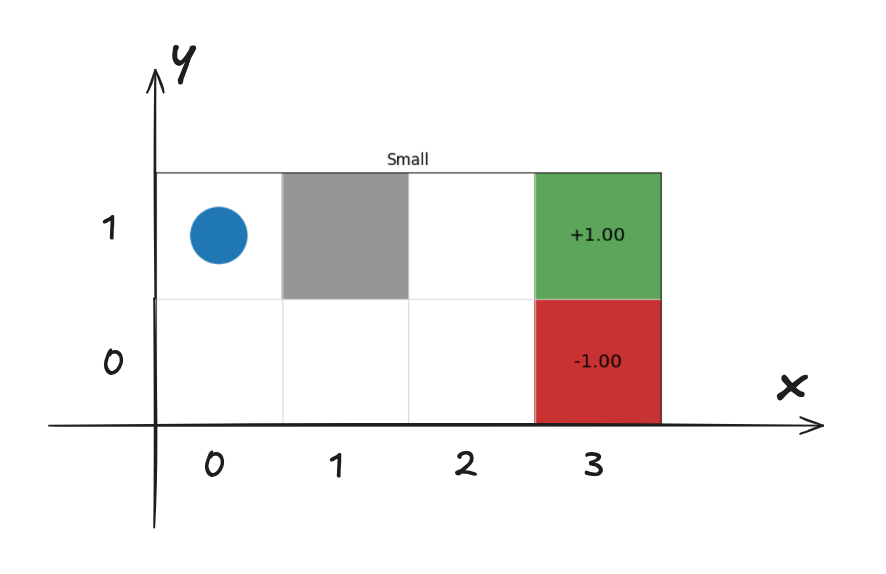

### Создание и отрисовка

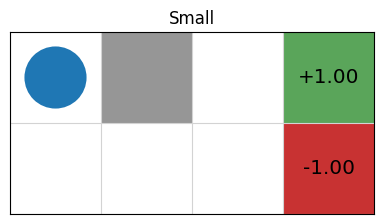

In [ ]:
world = GridWorld(height=2, width=4, blocked_states=[(1, 1)], initial_state=(0, 1))
rendering = world.visualise(title="Small", grid_size=1.)

In [ ]:
world.get_transitions((0, 1), world.DOWN)

[((0, 0), 0.8), ((0, 1), 0.2)]

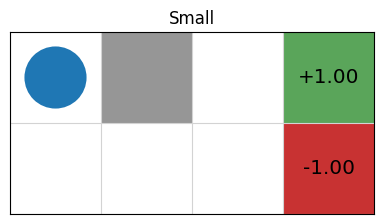

In [ ]:
world = GridWorld(height=2, width=4, blocked_states = [(1, 1)], initial_state=(0, 1), noise=0., action_cost=-1., discount_factor=0.9)
rendering = world.visualise(title="Small", grid_size=1.)

In [ ]:
world.get_transitions((0, 1), world.DOWN)

[((0, 0), 1.0)]

### Делаем ход

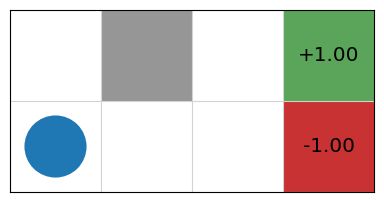

In [ ]:
state = world.get_initial_state()
(next_state, reward) = world.execute(state, world.DOWN)
rendering = world.visualise(agent_position=next_state, grid_size=1.)

### Действуем по политике

In [ ]:
from random import choice
from rich import print

In [ ]:
actions

['▲', '▼', '◄', '►', 'terminate']

#### Случайная политика

In [ ]:
states = world.get_states()
actions = world.get_actions()[:-1]
policy = {s: choice(actions) for s in states}
print(policy)

{
    ('terminal', 'terminal'): '►',
    (0, 0): '►',
    (0, 1): '▼',
    (1, 0): '►',
    (2, 0): '▲',
    (2, 1): '◄',
    (3, 0): '►',
    (3, 1): '▲'
}

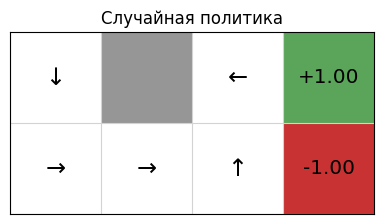

In [ ]:
image = world.visualise_policy(policy, title="Случайная политика", grid_size=1.)

total=-1000.0

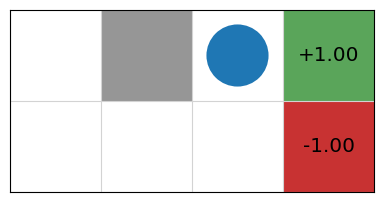

In [ ]:
last_state, total = world.execute_policy(policy, episodes=1)
print(f"{total=}")
rendering = world.visualise(agent_position=last_state, grid_size=1.)

#### Заведомо плохая политика

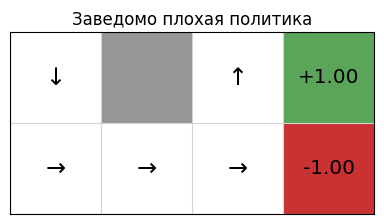

In [ ]:
policy = {
    (0, 0): world.RIGHT,
    (0, 1): world.DOWN,
    (1, 0): world.RIGHT,
    (2, 0): world.RIGHT,
    (2, 1): world.UP,
    (3, 0): world.TERMINATE,
    (3, 1): world.TERMINATE
}
image = world.visualise_policy(policy, title="Заведомо плохая политика", grid_size=1.)

total=-5.0

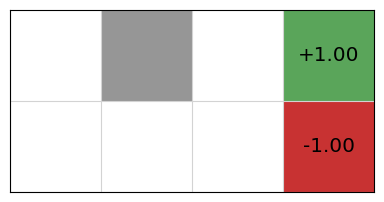

In [ ]:
last_state, total = world.execute_policy(policy, episodes=1)
print(f"{total=}")
rendering = world.visualise(agent_position=last_state, grid_size=1.)

 #### Оптимальная политика

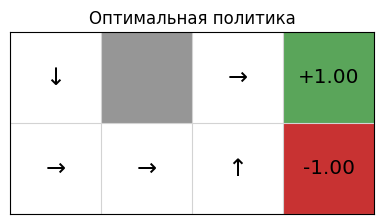

total=-4.0

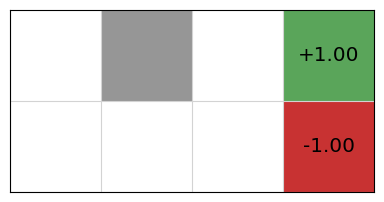

In [ ]:
policy = {
    (0, 0): world.RIGHT,
    (0, 1): world.DOWN,
    (1, 0): world.RIGHT,
    (2, 0): world.UP,
    (2, 1): world.RIGHT,
    (3, 0): world.TERMINATE,
    (3, 1): world.TERMINATE
}
image = world.visualise_policy(policy, title="Оптимальная политика", grid_size=1.)
last_state, total = world.execute_policy(policy, episodes=1)
print(f"{total=}")
rendering = world.visualise(agent_position=last_state, grid_size=1.)

## Value Iteration

#### Реализация

In [ ]:
class ValueIteration:
    def __init__(self, mdp):
        self.mdp = mdp
        self.V = defaultdict(lambda: 0.0)
        self.Q = defaultdict(lambda: 0.0)

    def fit(self, max_iterations=100, theta=0.001, verbose=False):
        for i in range(max_iterations):
            if verbose and i < 5:
                self.mdp.visualise_q_function(self.Q, grid_size=1., title=f"\nIteration {i}, Q")
                self.mdp.visualise_value_function(self.V, grid_size=1., title=f"\nIteration {i}, V")

            delta = 0.0
            new_values = defaultdict(lambda: 0.0)
            for state in self.mdp.get_states():
                for action in self.mdp.get_actions(state):
                    new_value = 0.0
                    for (new_state, probability) in self.mdp.get_transitions(state, action):
                        reward = self.mdp.get_reward(state, action, new_state)
                        new_value += probability * (reward + (self.mdp.get_discount_factor() * self.V[new_state]))
                    self.Q[(state, action)] = new_value

                # V(s) = max_a{Q(s, a)}
                max_q = float('-inf')
                arg_max_q = None
                for action in self.mdp.get_actions(state):
                    if max_q < self.Q[(state, action)]:
                        max_q = self.Q[(state, action)]
                        arg_max_q = action

                delta = max(delta, abs(self.V[state] - max_q))
                new_values[state] = max_q

            self.V = new_values.copy()
            print(f'iteration: {i}, max_delta: {delta}')
            # Terminate if the value function has converged
            if delta < theta:
                return (f'Total {i} iterations')

#### Пробуем со стандартными параметрами

In [ ]:
model_vi = ValueIteration(world)
model_vi.fit()

iteration: 0, max_delta: 1.0

iteration: 1, max_delta: 0.9

iteration: 2, max_delta: 0.81

iteration: 3, max_delta: 0.7290000000000001

iteration: 4, max_delta: 0.6561000000000003

iteration: 5, max_delta: 0.5904900000000004

iteration: 6, max_delta: 0.5314410000000005

iteration: 7, max_delta: 0.47829690000000014

iteration: 8, max_delta: 0.43046721000000066

iteration: 9, max_delta: 0.38742048900000015

iteration: 10, max_delta: 0.3486784401000005

iteration: 11, max_delta: 0.3138105960900006

iteration: 12, max_delta: 0.28242953648100055

iteration: 13, max_delta: 0.25418658283290085

iteration: 14, max_delta: 0.2287679245496106

iteration: 15, max_delta: 0.20589113209465015

iteration: 16, max_delta: 0.18530201888518505

iteration: 17, max_delta: 0.16677181699666654

iteration: 18, max_delta: 0.15009463529700007

iteration: 19, max_delta: 0.13508517176730006

iteration: 20, max_delta: 0.12157665459057032

iteration: 21, max_delta: 0.10941898913151338

iteration: 22, max_delta: 0.09847709021836248

iteration: 23, max_delta: 0.08862938119652597

iteration: 24, max_delta: 0.07976644307687408

iteration: 25, max_delta: 0.07178979876918667

iteration: 26, max_delta: 0.0646108188922696

iteration: 27, max_delta: 0.05814973700304371

iteration: 28, max_delta: 0.052334763302736675

iteration: 29, max_delta: 0.047101286972463186

iteration: 30, max_delta: 0.04239115827521722

iteration: 31, max_delta: 0.03815204244769621

iteration: 32, max_delta: 0.034336838202925435

iteration: 33, max_delta: 0.030903154382633247

iteration: 34, max_delta: 0.02781283894437081

iteration: 35, max_delta: 0.02503155504993515

iteration: 36, max_delta: 0.02252839954494057

iteration: 37, max_delta: 0.020275559590445802

iteration: 38, max_delta: 0.018248003631402554

iteration: 39, max_delta: 0.016423203268264075

iteration: 40, max_delta: 0.014780882941439089

iteration: 41, max_delta: 0.013302794647293226

iteration: 42, max_delta: 0.011972515182565147

iteration: 43, max_delta: 0.010775263664310586

iteration: 44, max_delta: 0.009697737297880593

iteration: 45, max_delta: 0.008727963568089692

iteration: 46, max_delta: 0.007855167211282321

iteration: 47, max_delta: 0.0070696504901519575

iteration: 48, max_delta: 0.0063626854411378275

iteration: 49, max_delta: 0.005726416897022801

iteration: 50, max_delta: 0.0051537752073222975

iteration: 51, max_delta: 0.004638397686591134

iteration: 52, max_delta: 0.004174557917933086

iteration: 53, max_delta: 0.003757102126137113

iteration: 54, max_delta: 0.0033813919135248227

iteration: 55, max_delta: 0.003043252722170209

iteration: 56, max_delta: 0.002738927449954076

iteration: 57, max_delta: 0.0024650347049597343

iteration: 58, max_delta: 0.002218531234461807

iteration: 59, max_delta: 0.0019966781110163367

iteration: 60, max_delta: 0.0017970102999154136

iteration: 61, max_delta: 0.0016173092699247604

iteration: 62, max_delta: 0.0014555783429326397

iteration: 63, max_delta: 0.0013100205086384875

iteration: 64, max_delta: 0.0011790184577744611

iteration: 65, max_delta: 0.0010611166119982585

iteration: 66, max_delta: 0.0009550049507964786

'Total 66 iterations'

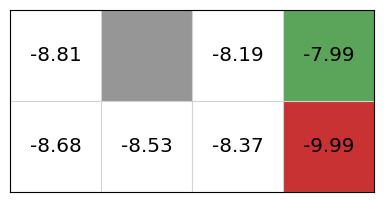

In [ ]:
world.visualise_value_function(model_vi.V, grid_size=1.)

Что будет, если увеличить коэффициент дисконтирования: сойдемся быстрее или медленнее?

#### Без дисконтирования

In [ ]:
world.get_transitions((2, 0), world.RIGHT)

[((3, 0), 1.0)]

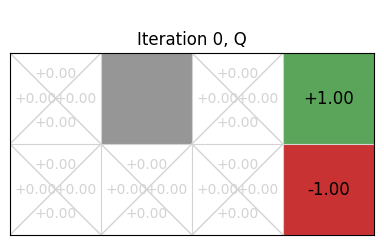

iteration: 0, max_delta: 1.0

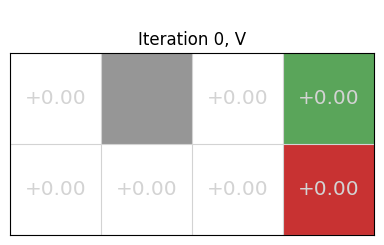

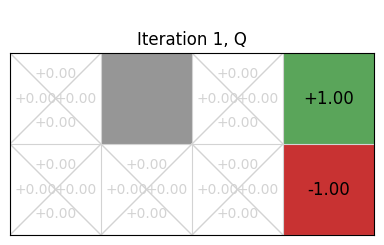

iteration: 1, max_delta: 1.0

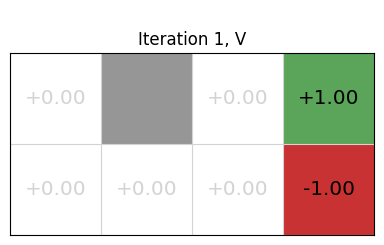

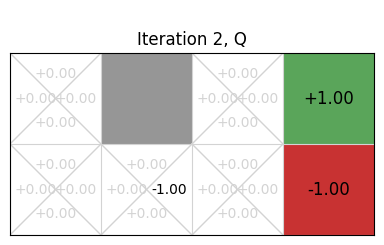

iteration: 2, max_delta: 1.0

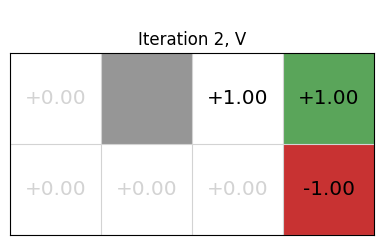

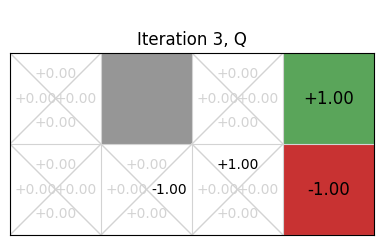

iteration: 3, max_delta: 1.0

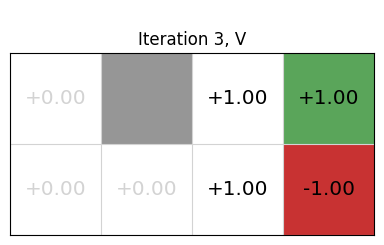

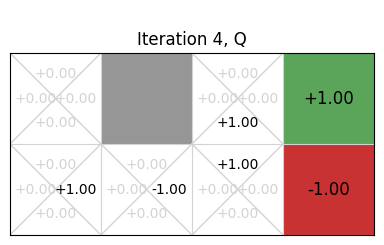

iteration: 4, max_delta: 1.0

iteration: 5, max_delta: 1.0

iteration: 6, max_delta: 0.0

'Total 6 iterations'

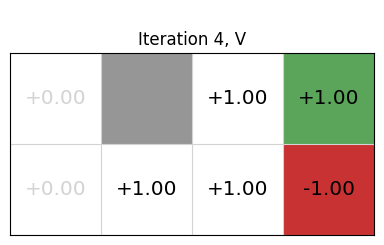

In [ ]:
world = GridWorld(height=2, width=4, blocked_states = [(1, 1)], initial_state=(0, 1), noise=0., action_cost=0., discount_factor=1)
model_vi = ValueIteration(world)
model_vi.fit(verbose=True)

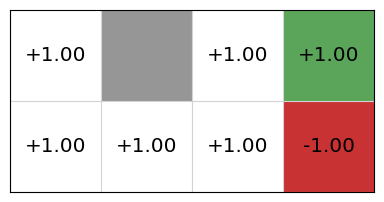

In [ ]:
world.visualise_value_function(model_vi.V, grid_size=1.)

#### С очень большим дисконтированием

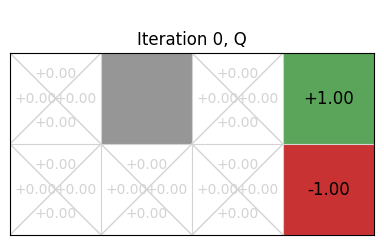

iteration: 0, max_delta: 1.0

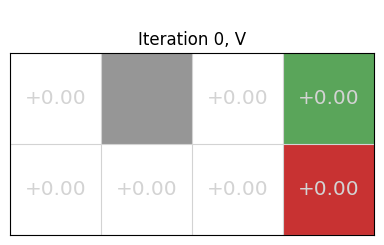

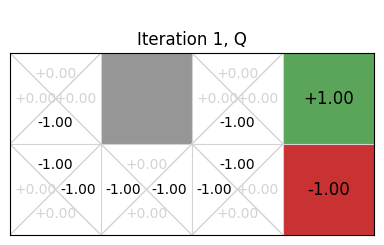

iteration: 1, max_delta: 0.5

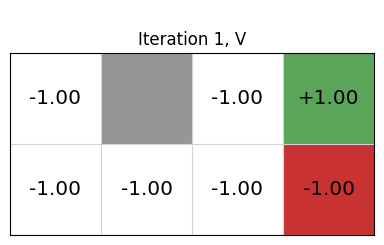

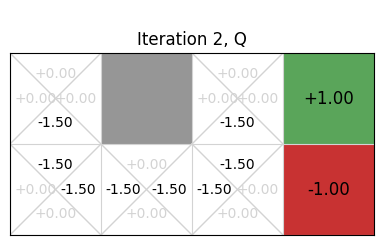

iteration: 2, max_delta: 0.25

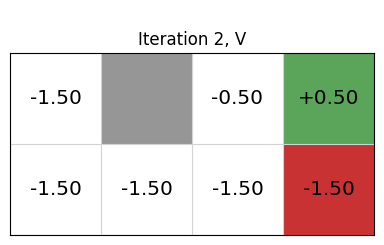

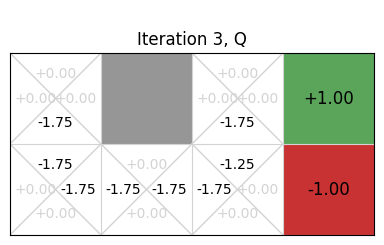

iteration: 3, max_delta: 0.125

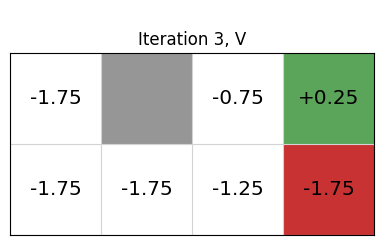

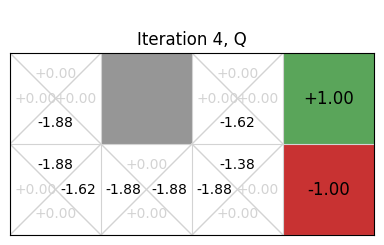

iteration: 4, max_delta: 0.0625

iteration: 5, max_delta: 0.03125

iteration: 6, max_delta: 0.015625

iteration: 7, max_delta: 0.0078125

iteration: 8, max_delta: 0.00390625

iteration: 9, max_delta: 0.001953125

iteration: 10, max_delta: 0.0009765625

'Total 10 iterations'

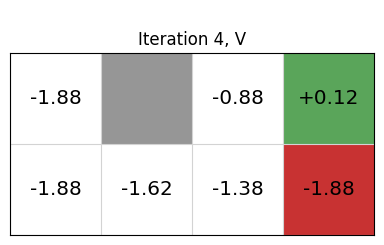

In [ ]:
world = GridWorld(height=2, width=4, blocked_states = [(1, 1)], initial_state=(0, 1), noise=0., action_cost=-1., discount_factor=0.5)
model_vi = ValueIteration(world)
model_vi.fit(verbose=True)

##

# Среда №2

## Описание

#### **CartPole**

* **Документация**: https://gymnasium.farama.org/environments/classic_control/cart_pole/

* **Действия:**

   * **0:** ⬅️ Move left

   * **1:** ➡️ Move right

* **Состояния:**

<img src="https://i.ibb.co/Pbyq3v2/Screenshot-2025-04-14-at-16-25-08.png" alt="Тут должно было быть описание состояний" border="0">

* **Цель:**

Удерживать стержень как можно дольше (свободный кончик стержня не должен касаться поверхности)

Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

* **Награды:**

`+1` за каждый шаг, когда мы не проиграли (на терминальном -- тоже)

* **Начальное состояние:**

`(-0.05, 0.05, 0.0, 0.0)`

* **Конец:**

  * **Termination:** Pole Angle > ±12°

  * **Termination:** Cart Position > ±2.4 (центр тележки за границами экрана)

  * **Truncation:** Episode length > 500




### Иллюстрация 1

<img src="https://i.sstatic.net/cZ483.gif" width="200">



### Иллюстрация 2

По сути это так:

<img src="https://timallanwheeler.com/blog/wp-content/uploads/2022/11/cartpole_lqr-1.gif">

## Архитектура

* **Вход:** Состояние (4 неотмасштабированных числа)
* **Выход:** Значения Q-функции для каждого действия




Наша модель будет представлять собой нейронную сеть, которая учитывает разницу между текущим и предыдущим экранами. Она имеет два выхода, представляющих собой $Q(s, left)$ и $Q(s, right)$ (где $s$ - вход сети).

По сути, сеть пытается предсказать ожидаемый реворд от каждого действия с учетом текущих входных данных.

 #### Схема инференса

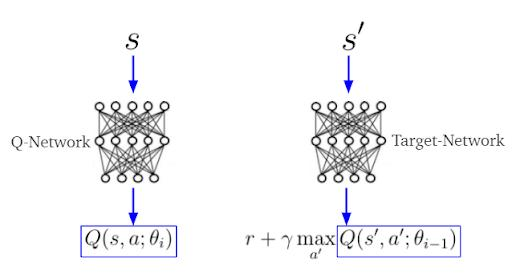

#### Схема обучения

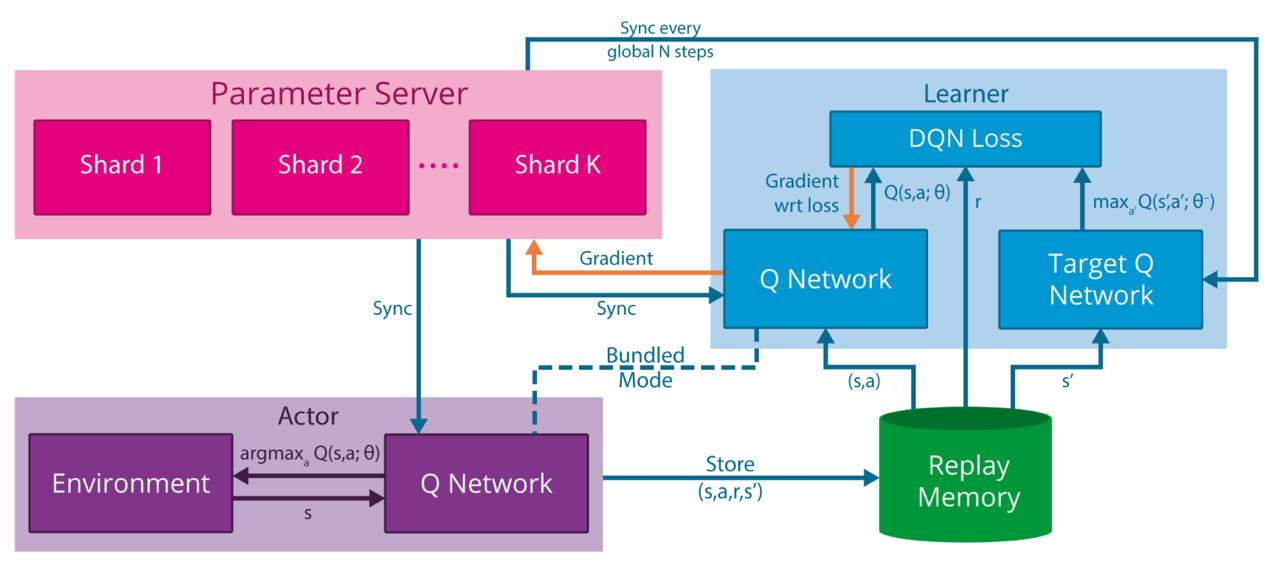

## Replay Memory

Переходы извлекаются путем случайной выборки, что позволяет избежать корреляции между наблюдениями. Это значительно стабилизирует и улучшает процедуру обучения DQN.

Нам потребуется структура дек:

**Очередь** — структура данных, в которой новые элементы добавляются в конец очереди, а удаление происходит из начала, то есть реализуется принцип «первым вошёл — первым вышел».  
pmpu.space

**Дек** (двухсторонняя очередь) — структура, в которой добавление новых элементов и удаление существующих производится с обоих концов. Дек работает одновременно по принципам FIFO и LIFO, поэтому на нём можно реализовать как стек, так и очередь.

In [ ]:
from dataclasses import dataclass

@dataclass
class Transition:
    state: tuple
    action: int
    next_state: tuple
    reward: int

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Hyperparameters and utilities


* `select_action` - выбор действия в соответствии с эпсилон-жадной политикой.
   * Иногда мы будем использовать нашу модель для выбора действия, а иногда - просто равномерную выборку.
   * Вероятность выбора случайного действия будет начинаться с `EPS_START` и экспоненциально убывать по направлению к `EPS_END`. `EPS_DECAY` управляет скоростью затухания.

* `plot_durations` - помощник для построения графика продолжительности эпизодов, а также среднего значения за последние 100 эпизодов (показатель, используемый в оценках).

   * График будет находиться под ячейкой, содержащей основной цикл обучения, и обновляться после каждого эпизода.
   * По умолчанию продолжительность эпизода в CartPole 500 действий. Если обученный агент сможет удержать шест вертикально на протяжении 500 эпизодов - можно считать, что он хорошо обучился

In [ ]:
# BATCH_SIZE - количество эпизодов, отобранных из буфера воспроизведения
# GAMMA - коэффициент дисконтирования
# EPS_START - начальное значение эпсилон
# EPS_END - конечное значение эпсилон
# EPS_DECAY - скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
# TAU - скорость обновления целевой сети
# LR - скорость обучения оптимизатора ``AdamW``.

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000

# Среда
env = gym.make("CartPole-v1")

# Получить число действий
n_actions = env.action_space.n

# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

# Инициилизировать сети: целевую и политики
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)
steps_done = 0

# Массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [ ]:
# еpsilon-жадная стратегия выбора действия
def select_action(state):
    global steps_done  # глобальный шаги для убывания epsilon

    # случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()

    # установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    # увеличиваем счетчик шагов
    steps_done += 1

    # если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места,
            # где был найден максимальный элемент,
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначы выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

Функция `optimize_model` выполняет один шаг оптимизации.

* Производит выборку, конкатенирует все тензоры в один, вычисляет
$Q(s_t, a_t)$ и $V(s_{t+1}) = max_aQ(s_{t+1},a)$ и объединяет их в Loss.

* По определению мы задаем $V(s)=0$, если $s$ является терминальным состоянием.

* Для повышения устойчивости мы также используем целевую сеть для вычисления $V(s_{t+1})$.

* Целевая сеть обновляется на каждом шаге с помощью __мягкого обновления__, управляемого гиперпараметром `TAU`.

In [ ]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return

    # Получить из памяти батч
    batch = memory.sample(batch_size)

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s.next_state is not None, batch)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s.next_state for s in batch if s.next_state is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat([b.state for b in batch])
    action_batch = torch.cat([b.action for b in batch])
    reward_batch = torch.cat([b.reward for b in batch])

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

**Основной цикл обучения**

1. В начале мы сбрасываем окружение и получаем тензор начального `state`.
2. Затем мы выбираем действие, выполняем его, наблюдаем следующее состояние и вознаграждение (всегда 1) и один раз оптимизируем нашу модель.
3. Когда эпизод заканчивается (модель не работает), мы перезапускаем цикл.


Обучение RL-агентов может быть случайным процессом, поэтому перезапуск обучения может дать лучшие результаты, если сходимость не наблюдается.

In [ ]:
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)

        # Объединяем done по двум конечным состояниям
        done = terminated or truncated

        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        this_transition = Transition(state=state, action=action, next_state=next_state, reward=reward)
        memory.push(this_transition)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 − τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████| 500/500 [07:33<00:00,  1.10it/s]

Complete


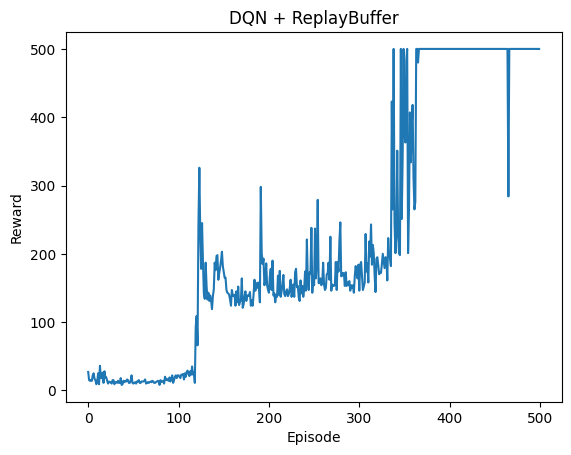

In [ ]:
# Вычисление скользящего среднего
window_size = 1
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()